<a href="https://colab.research.google.com/github/Thejaswini09/Malarial_Cells/blob/main/deeplearning_detectingmalariacells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.layers as k
from PIL import Image
from tqdm.notebook import tqdm
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"thejaswiniraju","key":"5b84bf15013d9d85c360f822c7be4421"}'}

In [ ]:
import zipfile
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 99% 670M/675M [00:05<00:00, 92.4MB/s]
100% 675M/675M [00:05<00:00, 138MB/s] 


In [ ]:
zip_ref = zipfile.ZipFile('/content/cell-images-for-detecting-malaria.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content') #Extracts the files into the /tmp folder
zip_ref.close()

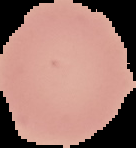

In [ ]:
load_img('/content/cell_images/Uninfected/C100P61ThinF_IMG_20150918_144823_cell_151.png')

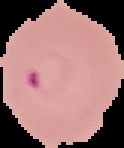

In [ ]:
load_img('/content/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_170.png')

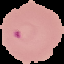

In [ ]:
load_img('/content/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_170.png', target_size=(64, 64))

In [ ]:
os.environ['KERAS_BACKEND'] = 'tensorflow'
np.random.seed(312)

In [ ]:
image_dir = '/content/cell_images/cell_images'
size = 64
dataset = []
label = []

In [ ]:
parasitized_img = os.listdir(image_dir + '/Parasitized')

for i, img_name in enumerate(tqdm(parasitized_img)):

    if (img_name.split('.')[1] == 'png'):
        image = cv2.imread(image_dir + '/Parasitized/' + img_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((size, size))

        dataset.append(np.array(image))
        label.append(0)

  0%|          | 0/13780 [00:00<?, ?it/s]

In [ ]:
len(parasitized_img)

13780

In [ ]:
uninfected_img = os.listdir(image_dir + '/Uninfected')

for i, img_name in enumerate(tqdm(uninfected_img)):

    if (img_name.split('.')[1] == 'png'):
        image = cv2.imread(image_dir + '/Uninfected/' + img_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((size, size))

        dataset.append(np.array(image))
        label.append(1)

  0%|          | 0/13780 [00:00<?, ?it/s]

In [ ]:
len(uninfected_img)

13780

In [ ]:
dataset = np.array(dataset)
label = np.array(label)

np.save('Dataset', dataset)
np.save('Label' , label)

In [ ]:
print('Dataset : {} | label : {}'.format(dataset.shape , label.shape))

Dataset : (27558, 64, 64, 3) | label : (27558,)


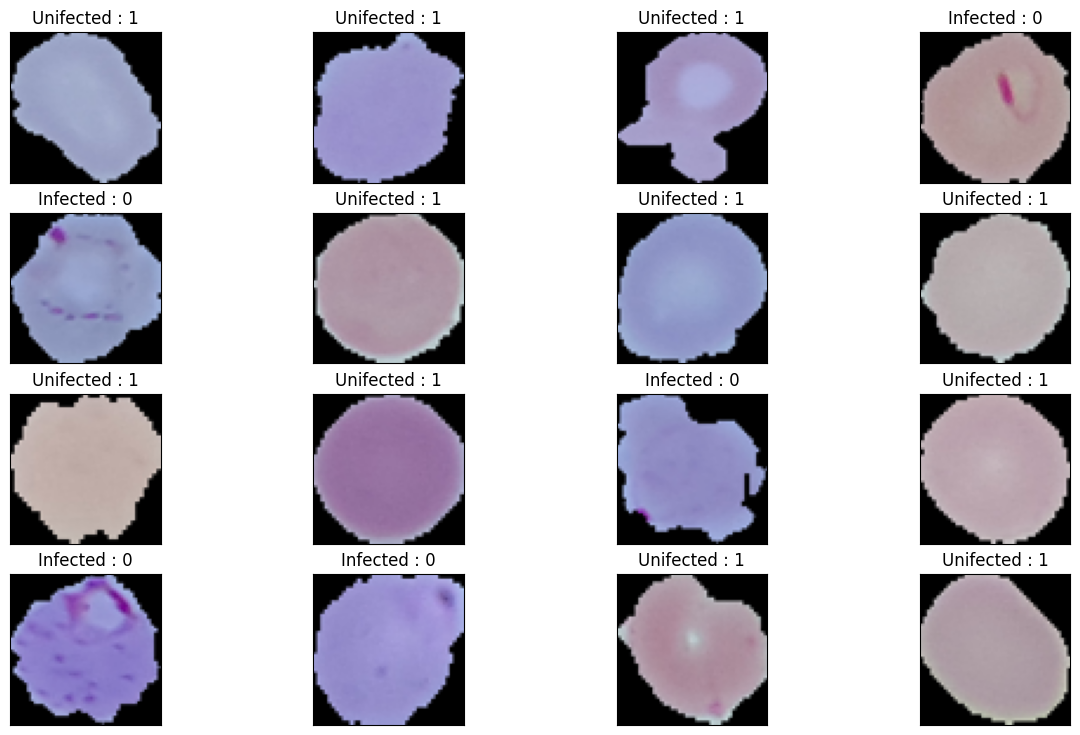

In [ ]:
plt.figure(1 , figsize = (15 , 9))
n = 0
for i in range(16):
    n += 1
    r = np.random.randint(0 , dataset.shape[0] , 1)
    plt.subplot( 4, 4 , n)
    plt.subplots_adjust(hspace = 0.2 , wspace = 0.2)
    plt.imshow(dataset[r[0]])
    plt.title('{} : {}'.format('Infected' if label[r[0]] == 0 else 'Unifected' ,
                               label[r[0]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(dataset, to_categorical(np.array(label)), test_size = 0.2, random_state = 0)


In [ ]:
len(xtrain)

22046

In [ ]:
len(xtest)

5512

In [ ]:
Input_shape = (size, size, 3)

inp = k.Input(shape = Input_shape)

conv1 = k.Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same')(inp)
pool1 = k.MaxPool2D(pool_size = (2,2))(conv1)
norm1 = k.BatchNormalization(axis = -1)(pool1)
drop1 = k.Dropout(rate = 0.2)(norm1)

conv2 = k.Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same')(drop1)
pool2 = k.MaxPool2D(pool_size = (2,2))(conv2)
norm2 = k.BatchNormalization(axis = -1)(pool2)
drop2 = k.Dropout(rate = 0.2)(norm2)

flat = k.Flatten()(drop2)
hidden1 = k.Dense(512, activation = 'relu')(flat)
norm3 = k.BatchNormalization(axis = -1)(hidden1)
drop3 = k.Dropout(rate = 0.2)(norm3)

hidden2 = k.Dense(256, activation = 'relu')(hidden1)
norm4 = k.BatchNormalization(axis = -1)(hidden2)
drop4 = k.Dropout(rate = 0.2)(norm4)

out = k.Dense(2, activation = 'sigmoid')(drop4)

In [ ]:
model = keras.Model(inputs = inp, outputs = out)
model.compile(optimizer = 'adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248  

In [ ]:
history = model.fit(x=np.array(xtrain), y=ytrain,
                   batch_size = 64, verbose = 1, epochs = 10,
                   validation_split = 0.1, shuffle = False)

Epoch 1/10
311/311 [==============================] - 155s 489ms/step - loss: 0.5234 - accuracy: 0.7507 - val_loss: 1.6779 - val_accuracy: 0.6240
Epoch 2/10
311/311 [==============================] - 152s 489ms/step - loss: 0.2420 - accuracy: 0.9120 - val_loss: 0.3351 - val_accuracy: 0.8952
Epoch 3/10
311/311 [==============================] - 151s 484ms/step - loss: 0.2036 - accuracy: 0.9262 - val_loss: 0.3176 - val_accuracy: 0.9079
Epoch 4/10
311/311 [==============================] - 147s 473ms/step - loss: 0.1823 - accuracy: 0.9328 - val_loss: 0.6825 - val_accuracy: 0.8685
Epoch 5/10
311/311 [==============================] - 148s 477ms/step - loss: 0.1574 - accuracy: 0.9443 - val_loss: 0.7939 - val_accuracy: 0.5918
Epoch 6/10
311/311 [==============================] - 149s 479ms/step - loss: 0.1320 - accuracy: 0.9524 - val_loss: 0.2659 - val_accuracy: 0.9211
Epoch 7/10
311/311 [==============================] - 147s 473ms/step - loss: 0.1170 - accuracy: 0.9571 - val_loss: 0.3315 -

In [ ]:
print('Test Accuracy : {:.2f}%'.format(model.evaluate(np.array(xtest), np.array(ytest))[1]*100))

173/173 [==============================] - 10s 57ms/step - loss: 0.1937 - accuracy: 0.9461
Test Accuracy : 94.61%


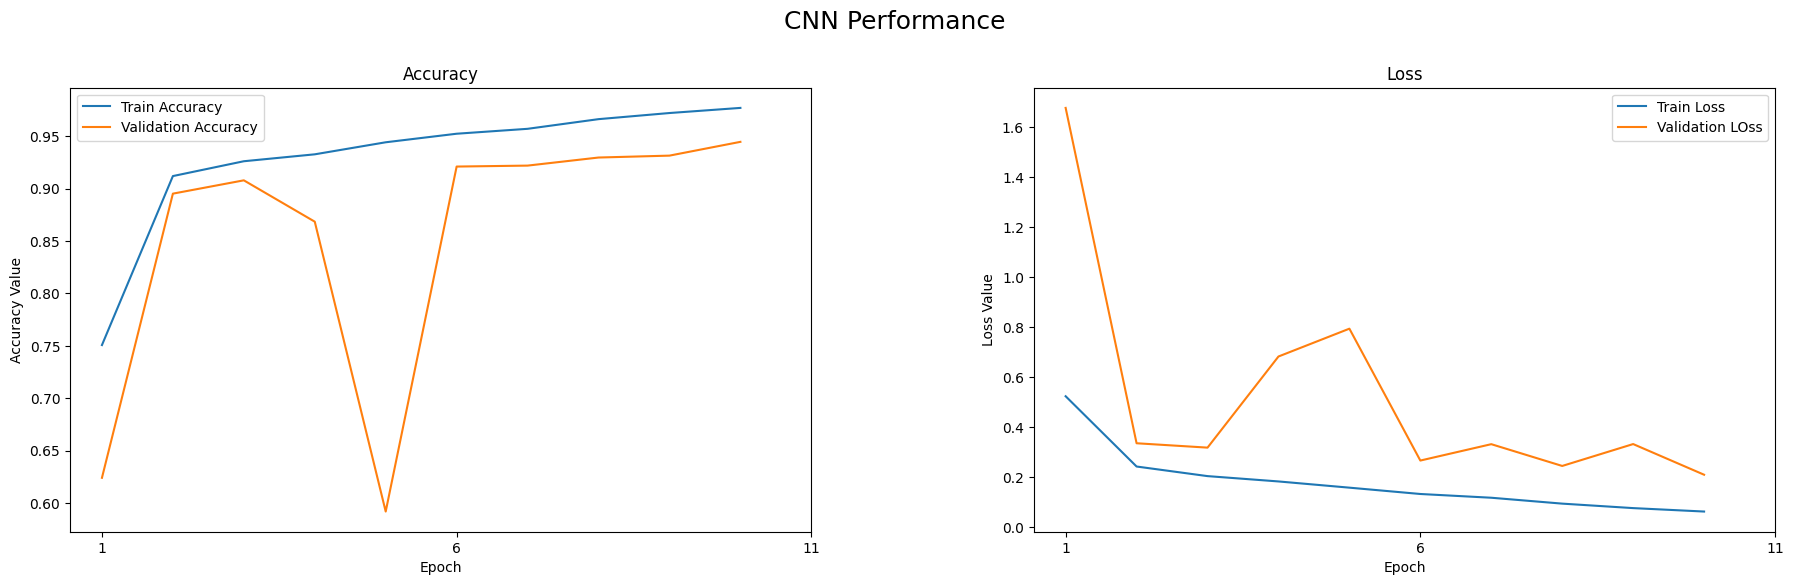

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))
t = f.suptitle('CNN Performance', fontsize=18)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))

ax1.plot(epoch_list, history.history['accuracy'], label = 'Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label = 'Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch + 1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc = "best")

ax2.plot(epoch_list, history.history['loss'], label = 'Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label = 'Validation LOss')
ax2.set_xticks(np.arange(1, max_epoch + 1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc = "best")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


ypred = model.predict(xtest)
predicted_labels = np.argmax(ypred, axis=1)

173/173 [==============================] - 10s 58ms/step


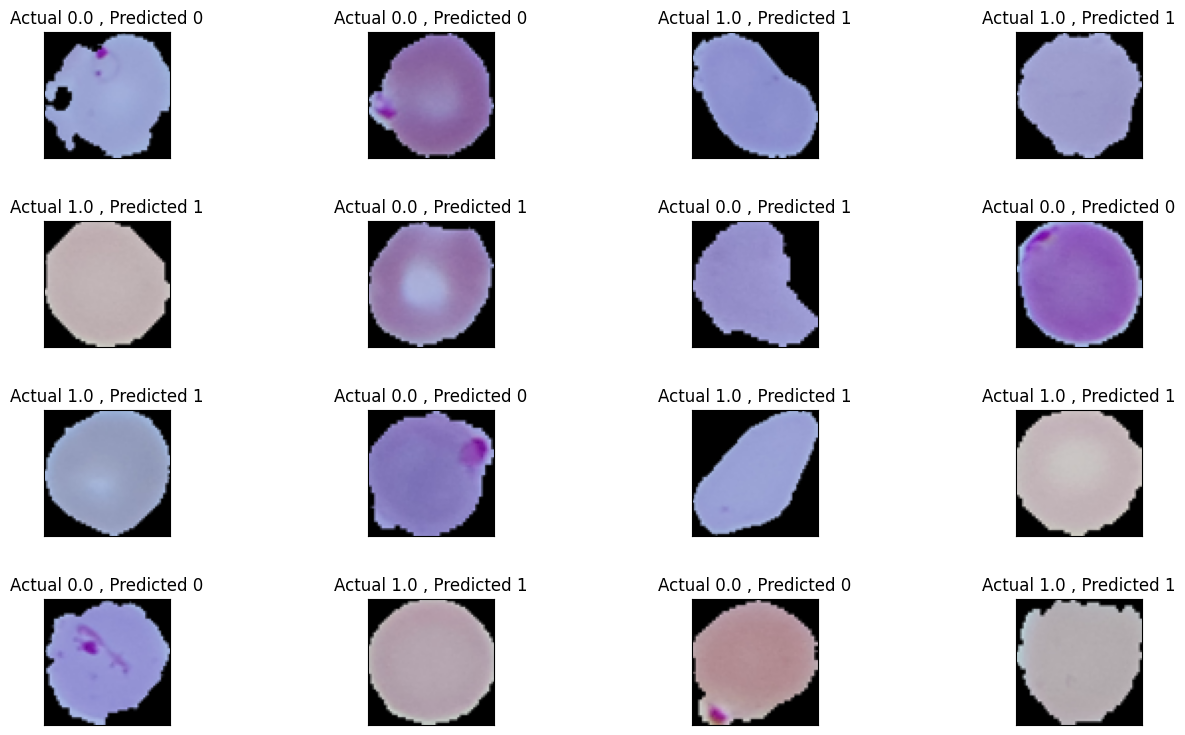

In [ ]:
plt.figure(1 , figsize = (15 , 9))
n = 0
for i in range(16):
    n += 1
    r = np.random.randint( 0  , xtest.shape[0] , 1)
    plt.subplot(4,4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.7)
    plt.imshow(xtest[r[0]])
    plt.title(f'Actual {ytest[r][0][1]} , Predicted {predicted_labels[r[0]]}' )
    plt.xticks([]) , plt.yticks([])

plt.show()